# Goal

The goal of this colab is to train a CNN on the IBM-NASA dataset for crop clasification.

# Installation

This module is dedicated for the installation of required packages for the usage of this collab.

In [4]:
!pip install segmentation-models-pytorch torch torchvision torchmetrics datasets albumentations rasterio tqdm pandas

# Imports

In [5]:
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
import json


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
from torch.utils.tensorboard import SummaryWriter


import pandas as pd

from torchmetrics.classification import Accuracy, JaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import ToTensor
from functools import lru_cache
from tqdm import tqdm

# Dataset loading
from datasets import load_dataset

# Google Drive Configuration

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

This block of code will configure all the requried global variables for the project. Some of this variables may have to be changed base on the user so make sure to check them out before executing the program.

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 14

# Trainign
EPOCHS = 50
BATCH_SIZE = 32

# Loading
NUM_WORKERS = 0

# Model params
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = None
LEARNING_RATE = 1e-5
DECODER_ATTENTION_TYPE = "scse"
DECODER_USER_NORM = False

# Data directories
DATA_DIR = "/content/drive/MyDrive/Universidad/TFG/Implementations/nasa_ibm/"
UNET_MODEL_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/models/"
UNET_GRAPH_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/"
UNET_METRICS_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/metrics/"

SPLIT_DIR = DATA_DIR + "splited"

TRAINING_IMAGE_DIR = DATA_DIR + "training_chips_merged"
TRAINING_MASK_DIR = DATA_DIR + "training_chips_mask"

VALIDATION_IMAGE_DIR = DATA_DIR + "training_chips_merged"
VALIDATION_MASK_DIR = DATA_DIR + "training_chips_mask"

TEST_IMAGE_DIR = DATA_DIR + "test_chips_merged"
TEST_MASK_DIR = DATA_DIR + "test_chips_mask"

In [8]:
class HFDGeoDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, image_dir, mask_dir, transform=None, is_original_dataset = True ):
        self.dataset = hf_dataset
        self.to_tensor = ToTensor()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.chip_ids = [item['text'] for item in self.dataset]

        self.image_paths = [os.path.join(image_dir, f"{chip_id}_merged.tif")
                           for chip_id in self.chip_ids]
        self.mask_paths = [os.path.join(mask_dir, f"{chip_id}.mask.tif")
                          for chip_id in self.chip_ids]


        self.use_memmap = True

    def __len__(self):
        return len(self.dataset)

    @lru_cache(maxsize=128)  # Cache recently accessed items
    def _load_image(self, image_path):
        """Load image with caching for repeated access."""
        try:
            with rasterio.open(image_path) as src:
                if self.use_memmap:
                    # Try memory-mapped reading when possible
                    image = src.read(out_shape=src.shape, masked=False)
                else:
                    image = src.read()
                return torch.from_numpy(image).type(torch.FloatTensor)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return empty tensor or handle error appropriately
            return torch.zeros((18, 224, 224), dtype=torch.float32)

    @lru_cache(maxsize=128)
    def _load_mask(self, mask_path):
        try:
            with rasterio.open(mask_path) as chip_mask:
                mask = chip_mask.read(1)
                return torch.from_numpy(mask).type(torch.LongTensor)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return torch.zeros((224, 224), dtype=torch.long)

    def _normalize_per_band(self, image):
        normalized = np.zeros_like(image, dtype=np.float32)

        for i in range(image.shape[0]):
            band = image[i]
            band_min = band.min()
            band_max = band.max()

            if band_max > band_min:
                normalized[i] = ((band - band_min)/(band_max - band_min))
            else:
                normalized[i] = np.zeros_like(band)

        return torch.from_numpy(normalized).float()

    def __getitem__(self, idx):
        chip_id = self.dataset[idx]['text']
        image_path = self.image_paths[idx]
        mask_path  = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask  = self._load_mask(mask_path)

        image = self._normalize_per_band(image)


        return image, mask





def create_datasets(dataset, image_dirs, mask_dirs, transform = None):
    # Create train and validation datasets
    train_dataset = HFDGeoDataset(
        dataset['train'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    val_dataset = HFDGeoDataset(
        dataset['validation'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE, ):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader


def visualize_random_rgb_sample(dataset, bands=(2, 1, 0), figsize=(10, 5)):
    """
    Picks a random sample and displays specified bands as an RGB composite,
    with per-band min/max normalization for proper visibility.

    Args:
        dataset: your HFDGeoDataset instance
        bands (tuple of int): which bands to use for R, G, B
        figsize (tuple): figure size in inches
    """
    # 1) Pick a random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]       # image: Tensor[18, H, W], mask: Tensor[H, W]

    # 2) Select just the three bands and convert to a HxWx3 NumPy array
    img_bands = image[list(bands), ...]            # shape = (3, H, W)
    img_np = img_bands.permute(1, 2, 0).numpy()    # shape = (H, W, 3)

    print( image )

    # 3) Per-band min/max normalization
    for c in range(3):
        band = img_np[..., c]
        mn, mx = band.min(), band.max()
        img_np[..., c] = (band - mn) / (mx - mn + 1e-6)

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img_np)
    ax1.set_title(f"Sample #{idx} RGB (bands {bands})")
    ax1.axis("off")

    ax2.imshow(mask.numpy(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

<ipython-input-8-ca4464871695>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))


tensor([[[0.1511, 0.1752, 0.1636,  ..., 0.1506, 0.1455, 0.1430],
         [0.1692, 0.1672, 0.1495,  ..., 0.1722, 0.1692, 0.1556],
         [0.1611, 0.1445, 0.1420,  ..., 0.1762, 0.1697, 0.1546],
         ...,
         [0.3243, 0.2790, 0.2513,  ..., 0.4496, 0.4300, 0.4058],
         [0.3061, 0.2689, 0.2578,  ..., 0.4305, 0.4199, 0.4089],
         [0.2779, 0.2482, 0.2311,  ..., 0.4215, 0.4285, 0.4240]],

        [[0.2331, 0.2525, 0.2446,  ..., 0.1462, 0.1449, 0.1458],
         [0.2446, 0.2317, 0.2020,  ..., 0.1697, 0.1701, 0.1582],
         [0.2051, 0.1630, 0.1396,  ..., 0.1737, 0.1697, 0.1564],
         ...,
         [0.3748, 0.3398, 0.3168,  ..., 0.5755, 0.5419, 0.5064],
         [0.3646, 0.3288, 0.3177,  ..., 0.5326, 0.5202, 0.5082],
         [0.3425, 0.3093, 0.2849,  ..., 0.5228, 0.5304, 0.5259]],

        [[0.1878, 0.2305, 0.2165,  ..., 0.1571, 0.1431, 0.1459],
         [0.2129, 0.2157, 0.1942,  ..., 0.1994, 0.1974, 0.1722],
         [0.1970, 0.1595, 0.1499,  ..., 0.2065, 0.1998, 0.

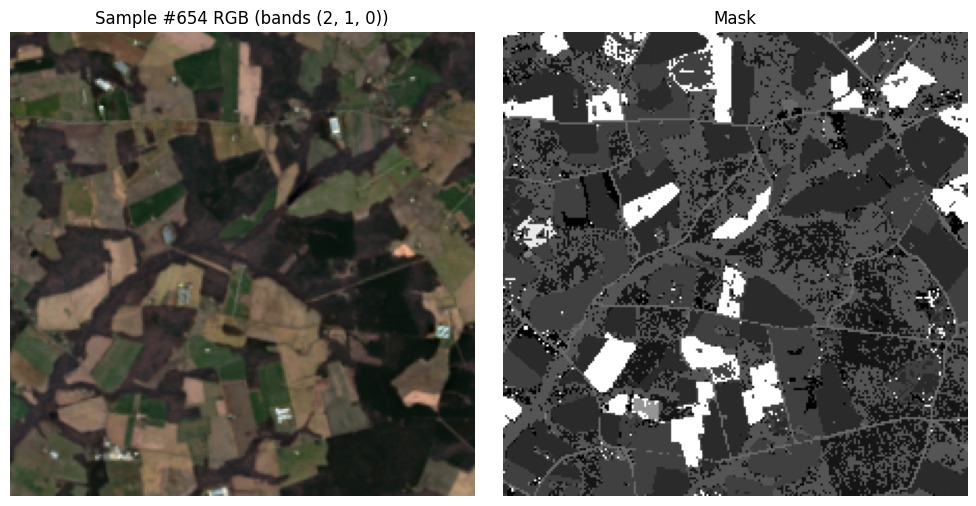

tensor([[[0.1089, 0.1259, 0.1473,  ..., 0.1577, 0.1695, 0.1449],
         [0.1165, 0.1316, 0.1416,  ..., 0.1596, 0.1761, 0.1586],
         [0.1217, 0.1392, 0.1094,  ..., 0.1567, 0.1785, 0.1634],
         ...,
         [0.2614, 0.2491, 0.2107,  ..., 0.1018, 0.1165, 0.1250],
         [0.2050, 0.1681, 0.1577,  ..., 0.1761, 0.1572, 0.1278],
         [0.1766, 0.1818, 0.2192,  ..., 0.1733, 0.1686, 0.1278]],

        [[0.2181, 0.2286, 0.2250,  ..., 0.1926, 0.2007, 0.1862],
         [0.2242, 0.2274, 0.2092,  ..., 0.1939, 0.2080, 0.1955],
         [0.2338, 0.2359, 0.1737,  ..., 0.1910, 0.2068, 0.1926],
         ...,
         [0.3122, 0.3033, 0.2738,  ..., 0.1300, 0.1478, 0.1543],
         [0.2492, 0.2128, 0.2266,  ..., 0.2254, 0.2036, 0.1648],
         [0.2266, 0.2536, 0.3243,  ..., 0.2237, 0.2169, 0.1632]],

        [[0.1523, 0.1576, 0.1715,  ..., 0.1882, 0.2042, 0.1812],
         [0.1583, 0.1628, 0.1677,  ..., 0.1955, 0.2191, 0.2021],
         [0.1663, 0.1739, 0.1370,  ..., 0.1798, 0.2125, 0.

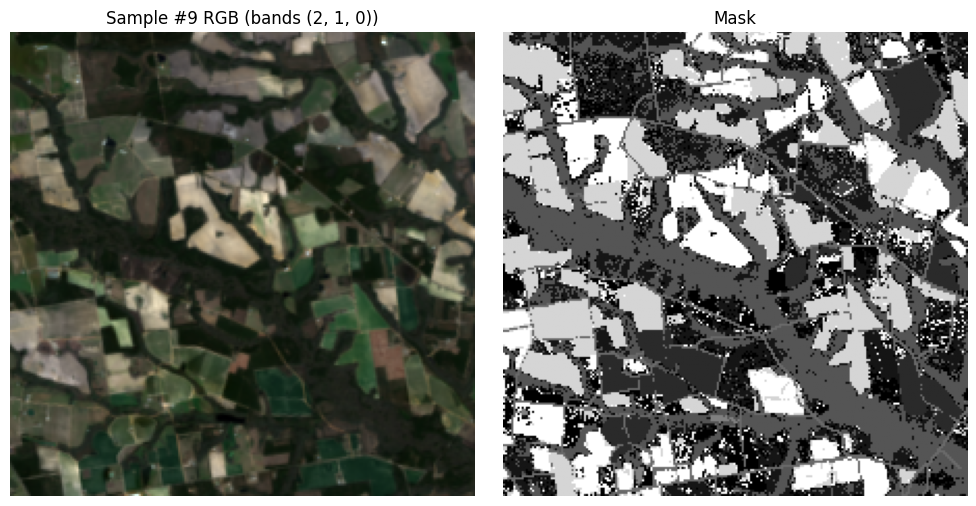

In [9]:
with open(os.path.join(SPLIT_DIR, 'dataset_splits.json')) as f:
    train_val_dataset = json.load(f)



# Create datasets
train_dataset, val_dataset = create_datasets(train_val_dataset, TRAINING_IMAGE_DIR, TRAINING_MASK_DIR)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)

visualize_random_rgb_sample(train_dataset)
visualize_random_rgb_sample(val_dataset)

In [10]:
model = UnetPlusPlus(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=18,
    classes=NUM_CLASSES,
    decoder_attention_type=DECODER_ATTENTION_TYPE,
    decoder_use_norm=DECODER_USER_NORM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

dice_loss = DiceLoss(mode="multiclass", from_logits=True)
focal_loss = FocalLoss(mode="multiclass", gamma=2.0)
ce_loss = nn.CrossEntropyLoss( ignore_index = 0 );


def criterion(preds, targets):
    """
    preds: raw logits,   shape [B, C, H, W]
    targets: integer labels, shape [B, H, W]
    """
    # ensure integer dtype
    targets = targets.long()

    # DiceLoss will internally one-hot `targets`
    L_dice  = dice_loss(preds, targets)
    # FocalLoss expects integer class labels
    L_focal = focal_loss(preds, targets)
    L_ce = ce_loss(preds, targets)

    return 1 * L_ce


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-10-1b0310b2e68a>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [11]:
accuracy = Accuracy(task="multiclass", average="macro",  num_classes=NUM_CLASSES).to(DEVICE)
iou = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
dice = DiceScore( num_classes=NUM_CLASSES, average="macro",   input_format="index" ).to(DEVICE)
miou = MeanIoU(num_classes=NUM_CLASSES, include_background= False,  input_format="index"  ).to(DEVICE)

Epoch 1/50:   0%|          | 0/78 [00:00<?, ?it/s]<ipython-input-8-ca4464871695>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))
Epoch 1/50: 100%|██████████| 78/78 [22:19<00:00, 17.17s/it]


[Epoch  0] Loss:  2.6992, Acc:   0.0739, IoU:   0.0202, Dice:  0.0262, mIoU:  0.0152


Epoch 1/50 [Val]: 100%|██████████| 20/20 [04:06<00:00, 12.34s/it]


[Epoch  0] Loss: 2.6419, Acc: 0.0842, IoU: 0.0218, Dice: 0.0263, mIoU: 0.0154


Epoch 2/50: 100%|██████████| 78/78 [10:25<00:00,  8.02s/it]


[Epoch  1] Loss:  2.6166, Acc:   0.0870, IoU:   0.0217, Dice:  0.0235, mIoU:  0.0139


Epoch 2/50 [Val]: 100%|██████████| 20/20 [02:17<00:00,  6.88s/it]


[Epoch  1] Loss: 2.5881, Acc: 0.0969, IoU: 0.0250, Dice: 0.0241, mIoU: 0.0144


Epoch 3/50: 100%|██████████| 78/78 [10:27<00:00,  8.04s/it]


[Epoch  2] Loss:  2.5714, Acc:   0.0965, IoU:   0.0253, Dice:  0.0255, mIoU:  0.0153


Epoch 3/50 [Val]: 100%|██████████| 20/20 [02:10<00:00,  6.51s/it]


[Epoch  2] Loss: 2.5462, Acc: 0.1077, IoU: 0.0293, Dice: 0.0277, mIoU: 0.0170


Epoch 4/50: 100%|██████████| 78/78 [09:48<00:00,  7.54s/it]


[Epoch  3] Loss:  2.5298, Acc:   0.1066, IoU:   0.0288, Dice:  0.0292, mIoU:  0.0179


Epoch 4/50 [Val]: 100%|██████████| 20/20 [02:30<00:00,  7.51s/it]


[Epoch  3] Loss: 2.5006, Acc: 0.1189, IoU: 0.0307, Dice: 0.0303, mIoU: 0.0187


Epoch 5/50: 100%|██████████| 78/78 [09:22<00:00,  7.21s/it]


[Epoch  4] Loss:  2.4776, Acc:   0.1117, IoU:   0.0332, Dice:  0.0346, mIoU:  0.0213


Epoch 5/50 [Val]: 100%|██████████| 20/20 [02:20<00:00,  7.00s/it]


[Epoch  4] Loss: 2.4398, Acc: 0.1243, IoU: 0.0388, Dice: 0.0397, mIoU: 0.0246


Epoch 6/50: 100%|██████████| 78/78 [09:27<00:00,  7.27s/it]


[Epoch  5] Loss:  2.4051, Acc:   0.1314, IoU:   0.0482, Dice:  0.0512, mIoU:  0.0321


Epoch 6/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.31s/it]


[Epoch  5] Loss: 2.3595, Acc: 0.1546, IoU: 0.0617, Dice: 0.0638, mIoU: 0.0409


Epoch 7/50: 100%|██████████| 78/78 [09:21<00:00,  7.19s/it]


[Epoch  6] Loss:  2.3148, Acc:   0.1539, IoU:   0.0693, Dice:  0.0745, mIoU:  0.0487


Epoch 7/50 [Val]: 100%|██████████| 20/20 [02:11<00:00,  6.56s/it]


[Epoch  6] Loss: 2.2610, Acc: 0.1631, IoU: 0.0782, Dice: 0.0842, mIoU: 0.0559


Epoch 8/50: 100%|██████████| 78/78 [10:02<00:00,  7.73s/it]


[Epoch  7] Loss:  2.2037, Acc:   0.1665, IoU:   0.0839, Dice:  0.0907, mIoU:  0.0615


Epoch 8/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.37s/it]


[Epoch  7] Loss: 2.1485, Acc: 0.1692, IoU: 0.0864, Dice: 0.0952, mIoU: 0.0652


Epoch 9/50: 100%|██████████| 78/78 [09:10<00:00,  7.06s/it]


[Epoch  8] Loss:  2.0968, Acc:   0.1760, IoU:   0.0950, Dice:  0.0993, mIoU:  0.0682


Epoch 9/50 [Val]: 100%|██████████| 20/20 [02:10<00:00,  6.51s/it]


[Epoch  8] Loss: 2.0457, Acc: 0.1858, IoU: 0.1049, Dice: 0.1065, mIoU: 0.0733


Epoch 10/50: 100%|██████████| 78/78 [09:58<00:00,  7.67s/it]


[Epoch  9] Loss:  2.0144, Acc:   0.2025, IoU:   0.1218, Dice:  0.1146, mIoU:  0.0793


Epoch 10/50 [Val]: 100%|██████████| 20/20 [01:30<00:00,  4.51s/it]


[Epoch  9] Loss: 2.0041, Acc: 0.2085, IoU: 0.1262, Dice: 0.1163, mIoU: 0.0815


Epoch 11/50: 100%|██████████| 78/78 [10:03<00:00,  7.73s/it]


[Epoch 10] Loss:  1.9502, Acc:   0.2231, IoU:   0.1385, Dice:  0.1256, mIoU:  0.0885


Epoch 11/50 [Val]: 100%|██████████| 20/20 [02:09<00:00,  6.49s/it]


[Epoch 10] Loss: 1.9349, Acc: 0.2254, IoU: 0.1400, Dice: 0.1290, mIoU: 0.0913


Epoch 12/50: 100%|██████████| 78/78 [09:14<00:00,  7.11s/it]


[Epoch 11] Loss:  1.9102, Acc:   0.2380, IoU:   0.1488, Dice:  0.1333, mIoU:  0.0946


Epoch 12/50 [Val]: 100%|██████████| 20/20 [02:11<00:00,  6.55s/it]


[Epoch 11] Loss: 1.9042, Acc: 0.2452, IoU: 0.1540, Dice: 0.1365, mIoU: 0.0970


Epoch 13/50: 100%|██████████| 78/78 [09:33<00:00,  7.35s/it]


[Epoch 12] Loss:  1.8762, Acc:   0.2494, IoU:   0.1569, Dice:  0.1383, mIoU:  0.0989


Epoch 13/50 [Val]: 100%|██████████| 20/20 [02:24<00:00,  7.24s/it]


[Epoch 12] Loss: 1.8652, Acc: 0.2560, IoU: 0.1619, Dice: 0.1422, mIoU: 0.1015


Epoch 14/50: 100%|██████████| 78/78 [09:27<00:00,  7.27s/it]


[Epoch 13] Loss:  1.8495, Acc:   0.2594, IoU:   0.1642, Dice:  0.1422, mIoU:  0.1021


Epoch 14/50 [Val]: 100%|██████████| 20/20 [02:09<00:00,  6.49s/it]


[Epoch 13] Loss: 1.8470, Acc: 0.2577, IoU: 0.1637, Dice: 0.1434, mIoU: 0.1029


Epoch 15/50: 100%|██████████| 78/78 [09:55<00:00,  7.64s/it]


[Epoch 14] Loss:  1.8235, Acc:   0.2653, IoU:   0.1692, Dice:  0.1449, mIoU:  0.1045


Epoch 15/50 [Val]: 100%|██████████| 20/20 [02:11<00:00,  6.55s/it]


[Epoch 14] Loss: 1.8206, Acc: 0.2649, IoU: 0.1685, Dice: 0.1466, mIoU: 0.1061


Epoch 16/50: 100%|██████████| 78/78 [09:12<00:00,  7.09s/it]


[Epoch 15] Loss:  1.8025, Acc:   0.2732, IoU:   0.1755, Dice:  0.1489, mIoU:  0.1080


Epoch 16/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.30s/it]


[Epoch 15] Loss: 1.8060, Acc: 0.2698, IoU: 0.1739, Dice: 0.1487, mIoU: 0.1081


Epoch 17/50: 100%|██████████| 78/78 [09:51<00:00,  7.58s/it]


[Epoch 16] Loss:  1.7866, Acc:   0.2793, IoU:   0.1805, Dice:  0.1516, mIoU:  0.1101


Epoch 17/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.38s/it]


[Epoch 16] Loss: 1.7987, Acc: 0.2738, IoU: 0.1765, Dice: 0.1508, mIoU: 0.1096


Epoch 18/50: 100%|██████████| 78/78 [09:14<00:00,  7.11s/it]


[Epoch 17] Loss:  1.7703, Acc:   0.2854, IoU:   0.1855, Dice:  0.1547, mIoU:  0.1127


Epoch 18/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.25s/it]


[Epoch 17] Loss: 1.7794, Acc: 0.2738, IoU: 0.1779, Dice: 0.1513, mIoU: 0.1104


Epoch 19/50: 100%|██████████| 78/78 [09:47<00:00,  7.53s/it]


[Epoch 18] Loss:  1.7440, Acc:   0.2948, IoU:   0.1922, Dice:  0.1579, mIoU:  0.1156


Epoch 19/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.23s/it]


[Epoch 18] Loss: 1.7644, Acc: 0.2877, IoU: 0.1869, Dice: 0.1576, mIoU: 0.1148


Epoch 20/50: 100%|██████████| 78/78 [09:18<00:00,  7.15s/it]


[Epoch 19] Loss:  1.7335, Acc:   0.2980, IoU:   0.1952, Dice:  0.1590, mIoU:  0.1166


Epoch 20/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.29s/it]


[Epoch 19] Loss: 1.7543, Acc: 0.2897, IoU: 0.1909, Dice: 0.1598, mIoU: 0.1169


Epoch 21/50: 100%|██████████| 78/78 [09:44<00:00,  7.50s/it]


[Epoch 20] Loss:  1.7282, Acc:   0.3004, IoU:   0.1973, Dice:  0.1614, mIoU:  0.1186


Epoch 21/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.39s/it]


[Epoch 20] Loss: 1.7579, Acc: 0.3013, IoU: 0.1944, Dice: 0.1630, mIoU: 0.1189


Epoch 22/50: 100%|██████████| 78/78 [08:56<00:00,  6.88s/it]


[Epoch 21] Loss:  1.7057, Acc:   0.3068, IoU:   0.2023, Dice:  0.1641, mIoU:  0.1210


Epoch 22/50 [Val]: 100%|██████████| 20/20 [02:03<00:00,  6.18s/it]


[Epoch 21] Loss: 1.7450, Acc: 0.2845, IoU: 0.1878, Dice: 0.1601, mIoU: 0.1180


Epoch 23/50: 100%|██████████| 78/78 [09:01<00:00,  6.94s/it]


[Epoch 22] Loss:  1.6831, Acc:   0.3134, IoU:   0.2074, Dice:  0.1670, mIoU:  0.1237


Epoch 23/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.43s/it]


[Epoch 22] Loss: 1.7164, Acc: 0.3037, IoU: 0.1988, Dice: 0.1639, mIoU: 0.1214


Epoch 24/50: 100%|██████████| 78/78 [09:19<00:00,  7.18s/it]


[Epoch 23] Loss:  1.6765, Acc:   0.3175, IoU:   0.2106, Dice:  0.1682, mIoU:  0.1251


Epoch 24/50 [Val]: 100%|██████████| 20/20 [02:03<00:00,  6.15s/it]


[Epoch 23] Loss: 1.7219, Acc: 0.3039, IoU: 0.1996, Dice: 0.1637, mIoU: 0.1216


Epoch 25/50: 100%|██████████| 78/78 [09:26<00:00,  7.26s/it]


[Epoch 24] Loss:  1.6595, Acc:   0.3209, IoU:   0.2136, Dice:  0.1706, mIoU:  0.1269


Epoch 25/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.22s/it]


[Epoch 24] Loss: 1.7067, Acc: 0.3056, IoU: 0.2009, Dice: 0.1673, mIoU: 0.1241


Epoch 26/50: 100%|██████████| 78/78 [09:20<00:00,  7.19s/it]


[Epoch 25] Loss:  1.6445, Acc:   0.3259, IoU:   0.2171, Dice:  0.1728, mIoU:  0.1290


Epoch 26/50 [Val]: 100%|██████████| 20/20 [02:01<00:00,  6.06s/it]


[Epoch 25] Loss: 1.7011, Acc: 0.3213, IoU: 0.2082, Dice: 0.1704, mIoU: 0.1267


Epoch 27/50: 100%|██████████| 78/78 [08:51<00:00,  6.82s/it]


[Epoch 26] Loss:  1.6412, Acc:   0.3280, IoU:   0.2187, Dice:  0.1738, mIoU:  0.1300


Epoch 27/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.37s/it]


[Epoch 26] Loss: 1.6879, Acc: 0.3247, IoU: 0.2121, Dice: 0.1720, mIoU: 0.1284


Epoch 28/50: 100%|██████████| 78/78 [09:12<00:00,  7.09s/it]


[Epoch 27] Loss:  1.6263, Acc:   0.3336, IoU:   0.2226, Dice:  0.1762, mIoU:  0.1320


Epoch 28/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.34s/it]


[Epoch 27] Loss: 1.6870, Acc: 0.3173, IoU: 0.2111, Dice: 0.1711, mIoU: 0.1280


Epoch 29/50: 100%|██████████| 78/78 [09:13<00:00,  7.09s/it]


[Epoch 28] Loss:  1.6147, Acc:   0.3367, IoU:   0.2250, Dice:  0.1779, mIoU:  0.1335


Epoch 29/50 [Val]: 100%|██████████| 20/20 [01:44<00:00,  5.22s/it]


[Epoch 28] Loss: 1.6894, Acc: 0.3118, IoU: 0.2062, Dice: 0.1722, mIoU: 0.1295


Epoch 30/50: 100%|██████████| 78/78 [09:11<00:00,  7.07s/it]


[Epoch 29] Loss:  1.6071, Acc:   0.3406, IoU:   0.2286, Dice:  0.1793, mIoU:  0.1350


Epoch 30/50 [Val]: 100%|██████████| 20/20 [02:01<00:00,  6.06s/it]


[Epoch 29] Loss: 1.6684, Acc: 0.3227, IoU: 0.2143, Dice: 0.1766, mIoU: 0.1319


Epoch 31/50: 100%|██████████| 78/78 [08:51<00:00,  6.82s/it]


[Epoch 30] Loss:  1.5947, Acc:   0.3441, IoU:   0.2308, Dice:  0.1813, mIoU:  0.1364


Epoch 31/50 [Val]: 100%|██████████| 20/20 [02:02<00:00,  6.14s/it]


[Epoch 30] Loss: 1.6601, Acc: 0.3312, IoU: 0.2178, Dice: 0.1793, mIoU: 0.1346


Epoch 32/50: 100%|██████████| 78/78 [09:05<00:00,  7.00s/it]


[Epoch 31] Loss:  1.5872, Acc:   0.3466, IoU:   0.2328, Dice:  0.1824, mIoU:  0.1377


Epoch 32/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.42s/it]


[Epoch 31] Loss: 1.6701, Acc: 0.3166, IoU: 0.2153, Dice: 0.1740, mIoU: 0.1307


Epoch 33/50: 100%|██████████| 78/78 [09:50<00:00,  7.57s/it]


[Epoch 32] Loss:  1.5803, Acc:   0.3506, IoU:   0.2361, Dice:  0.1839, mIoU:  0.1390


Epoch 33/50 [Val]: 100%|██████████| 20/20 [02:01<00:00,  6.09s/it]


[Epoch 32] Loss: 1.6487, Acc: 0.3267, IoU: 0.2161, Dice: 0.1773, mIoU: 0.1333


Epoch 34/50: 100%|██████████| 78/78 [09:01<00:00,  6.94s/it]


[Epoch 33] Loss:  1.5664, Acc:   0.3554, IoU:   0.2392, Dice:  0.1863, mIoU:  0.1409


Epoch 34/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.21s/it]


[Epoch 33] Loss: 1.6510, Acc: 0.3258, IoU: 0.2172, Dice: 0.1790, mIoU: 0.1343


Epoch 35/50: 100%|██████████| 78/78 [09:11<00:00,  7.07s/it]


[Epoch 34] Loss:  1.5556, Acc:   0.3582, IoU:   0.2416, Dice:  0.1873, mIoU:  0.1422


Epoch 35/50 [Val]: 100%|██████████| 20/20 [02:28<00:00,  7.44s/it]


[Epoch 34] Loss: 1.6506, Acc: 0.3292, IoU: 0.2180, Dice: 0.1793, mIoU: 0.1349


Epoch 36/50: 100%|██████████| 78/78 [09:32<00:00,  7.33s/it]


[Epoch 35] Loss:  1.5464, Acc:   0.3614, IoU:   0.2444, Dice:  0.1892, mIoU:  0.1440


Epoch 36/50 [Val]: 100%|██████████| 20/20 [02:12<00:00,  6.60s/it]


[Epoch 35] Loss: 1.6515, Acc: 0.3389, IoU: 0.2214, Dice: 0.1821, mIoU: 0.1369


Epoch 37/50: 100%|██████████| 78/78 [09:47<00:00,  7.53s/it]


[Epoch 36] Loss:  1.5424, Acc:   0.3642, IoU:   0.2461, Dice:  0.1908, mIoU:  0.1453


Epoch 37/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.28s/it]


[Epoch 36] Loss: 1.6310, Acc: 0.3461, IoU: 0.2269, Dice: 0.1853, mIoU: 0.1400


Epoch 38/50: 100%|██████████| 78/78 [09:00<00:00,  6.93s/it]


[Epoch 37] Loss:  1.5342, Acc:   0.3669, IoU:   0.2480, Dice:  0.1919, mIoU:  0.1462


Epoch 38/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.25s/it]


[Epoch 37] Loss: 1.6422, Acc: 0.3424, IoU: 0.2241, Dice: 0.1831, mIoU: 0.1386


Epoch 39/50: 100%|██████████| 78/78 [08:51<00:00,  6.81s/it]


[Epoch 38] Loss:  1.5299, Acc:   0.3684, IoU:   0.2496, Dice:  0.1919, mIoU:  0.1467


Epoch 39/50 [Val]: 100%|██████████| 20/20 [02:01<00:00,  6.07s/it]


[Epoch 38] Loss: 1.6315, Acc: 0.3378, IoU: 0.2258, Dice: 0.1840, mIoU: 0.1395


Epoch 40/50: 100%|██████████| 78/78 [09:44<00:00,  7.50s/it]


[Epoch 39] Loss:  1.5261, Acc:   0.3700, IoU:   0.2508, Dice:  0.1938, mIoU:  0.1480


Epoch 40/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.41s/it]


[Epoch 39] Loss: 1.6405, Acc: 0.3259, IoU: 0.2201, Dice: 0.1824, mIoU: 0.1387


Epoch 41/50: 100%|██████████| 78/78 [09:07<00:00,  7.02s/it]


[Epoch 40] Loss:  1.5139, Acc:   0.3726, IoU:   0.2539, Dice:  0.1953, mIoU:  0.1498


Epoch 41/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.28s/it]


[Epoch 40] Loss: 1.6111, Acc: 0.3419, IoU: 0.2276, Dice: 0.1877, mIoU: 0.1426


Epoch 42/50: 100%|██████████| 78/78 [09:43<00:00,  7.49s/it]


[Epoch 41] Loss:  1.5023, Acc:   0.3765, IoU:   0.2560, Dice:  0.1968, mIoU:  0.1509


Epoch 42/50 [Val]: 100%|██████████| 20/20 [02:02<00:00,  6.13s/it]


[Epoch 41] Loss: 1.6267, Acc: 0.3419, IoU: 0.2260, Dice: 0.1868, mIoU: 0.1422


Epoch 43/50: 100%|██████████| 78/78 [09:00<00:00,  6.93s/it]


[Epoch 42] Loss:  1.4943, Acc:   0.3791, IoU:   0.2580, Dice:  0.1983, mIoU:  0.1523


Epoch 43/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.42s/it]


[Epoch 42] Loss: 1.6060, Acc: 0.3468, IoU: 0.2312, Dice: 0.1882, mIoU: 0.1435


Epoch 44/50: 100%|██████████| 78/78 [09:36<00:00,  7.39s/it]


[Epoch 43] Loss:  1.4939, Acc:   0.3808, IoU:   0.2597, Dice:  0.1990, mIoU:  0.1533


Epoch 44/50 [Val]: 100%|██████████| 20/20 [02:02<00:00,  6.10s/it]


[Epoch 43] Loss: 1.6037, Acc: 0.3432, IoU: 0.2312, Dice: 0.1897, mIoU: 0.1445


Epoch 45/50: 100%|██████████| 78/78 [08:59<00:00,  6.92s/it]


[Epoch 44] Loss:  1.4867, Acc:   0.3833, IoU:   0.2618, Dice:  0.2006, mIoU:  0.1544


Epoch 45/50 [Val]: 100%|██████████| 20/20 [02:03<00:00,  6.17s/it]


[Epoch 44] Loss: 1.6134, Acc: 0.3396, IoU: 0.2276, Dice: 0.1882, mIoU: 0.1438


Epoch 46/50: 100%|██████████| 78/78 [08:51<00:00,  6.81s/it]


[Epoch 45] Loss:  1.4868, Acc:   0.3839, IoU:   0.2620, Dice:  0.2008, mIoU:  0.1548


Epoch 46/50 [Val]: 100%|██████████| 20/20 [02:02<00:00,  6.14s/it]


[Epoch 45] Loss: 1.6027, Acc: 0.3620, IoU: 0.2379, Dice: 0.1940, mIoU: 0.1473


Epoch 47/50: 100%|██████████| 78/78 [09:16<00:00,  7.13s/it]


[Epoch 46] Loss:  1.4918, Acc:   0.3836, IoU:   0.2623, Dice:  0.2008, mIoU:  0.1548


Epoch 47/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.25s/it]


[Epoch 46] Loss: 1.6097, Acc: 0.3573, IoU: 0.2331, Dice: 0.1921, mIoU: 0.1458


Epoch 48/50: 100%|██████████| 78/78 [09:53<00:00,  7.61s/it]


[Epoch 47] Loss:  1.4757, Acc:   0.3890, IoU:   0.2666, Dice:  0.2033, mIoU:  0.1573


Epoch 48/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.45s/it]


[Epoch 47] Loss: 1.5980, Acc: 0.3505, IoU: 0.2342, Dice: 0.1920, mIoU: 0.1470


Epoch 49/50: 100%|██████████| 78/78 [09:13<00:00,  7.10s/it]


[Epoch 48] Loss:  1.4795, Acc:   0.3878, IoU:   0.2654, Dice:  0.2031, mIoU:  0.1572


Epoch 49/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.35s/it]


[Epoch 48] Loss: 1.6061, Acc: 0.3550, IoU: 0.2340, Dice: 0.1914, mIoU: 0.1454


Epoch 50/50: 100%|██████████| 78/78 [09:50<00:00,  7.58s/it]


[Epoch 49] Loss:  1.4710, Acc:   0.3893, IoU:   0.2664, Dice:  0.2041, mIoU:  0.1581


Epoch 50/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.32s/it]


[Epoch 49] Loss: 1.5948, Acc: 0.3482, IoU: 0.2371, Dice: 0.1928, mIoU: 0.1477


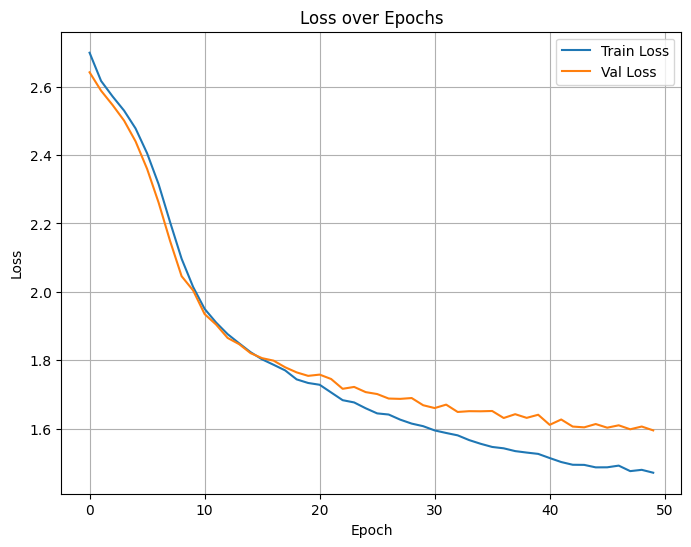

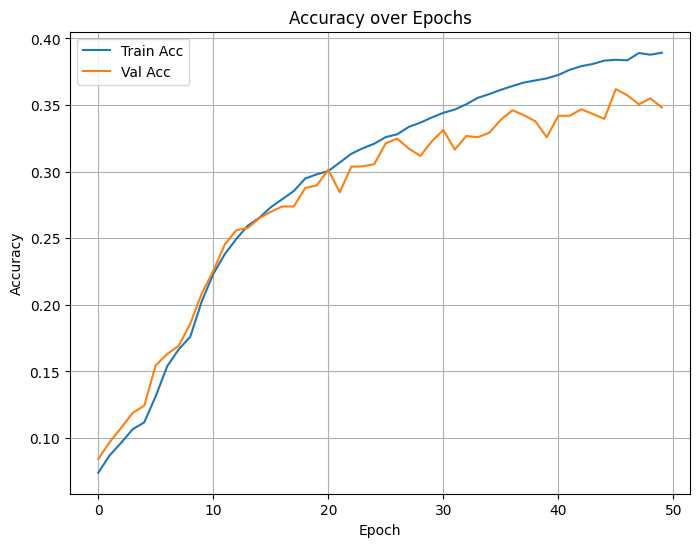

In [12]:


writer = SummaryWriter(log_dir="runs/experiment1")

labels = {
      0: "No Data",
      1: "Natural Vegetation",
      2: "Forest",
      3: "Corn",
      4: "Soybeans",
      5: "Wetlands",
      6: "Developed Barren",
      7: "Open Water",
      8: "Winter Wheat",
      9: "Alfalfa",
      10: "Fallow Idle Cropland",
      11: "Cotton",
      12: "Sorghum",
      13: "Other"
  }

train_losses, train_accs, train_ious, train_mious, train_dices = [], [], [], [], []
val_losses,   val_accs,   val_ious,   val_mious,  val_dices = [], [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = train_acc_sum = train_iou_sum = train_dice_sum = train_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    ### ——— TRAIN ———
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        accuracy.update(preds, masks)
        iou      .update(preds, masks)
        dice     .update(preds, masks)
        miou     .update(preds, masks)

        train_loss_sum  += loss.item()

    # Average metrics
    train_losses.append(train_loss_sum / len(train_loader))
    train_accs  .append(accuracy.compute().item())
    train_ious  .append(iou.compute().item())
    train_dices .append(dice.compute().item())
    train_mious .append(miou.compute().item())

    writer.add_scalar('Loss/train', train_losses[-1], epoch)
    writer.add_scalar('Accuracy/train', train_accs[-1], epoch)
    writer.add_scalar('IoU/train', train_ious[-1], epoch)
    writer.add_scalar('Dice/train', train_dices[-1], epoch)
    writer.add_scalar('mIoU/train', train_mious[-1], epoch)


    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss:  {train_losses[-1]:.4f}, "
        f"Acc:   {train_accs[-1]:.4f}, "
        f"IoU:   {train_ious[-1]:.4f}, "
        f"Dice:  {train_dices[-1]:.4f}, "
        f"mIoU:  {train_mious[-1]:.4f}"
    )

    ### ——— VALIDATION ———
    model.eval()
    val_loss_sum = val_acc_sum = val_iou_sum = val_dice_sum = val_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, masks)
            iou      .update(preds, masks)
            dice     .update(preds, masks)
            miou     .update(preds, masks)

            val_loss_sum  += loss.item()

    # Average metrics
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs  .append(accuracy.compute().item())
    val_ious  .append(iou.compute().item())
    val_dices .append(dice.compute().item())
    val_mious .append(miou.compute().item())

    # Log to TensorBoard
    writer.add_scalar('Loss/val', val_losses[-1], epoch)
    writer.add_scalar('Accuracy/val', val_accs[-1], epoch)
    writer.add_scalar('IoU/val', val_ious[-1], epoch)
    writer.add_scalar('Dice/val', val_dices[-1], epoch)
    writer.add_scalar('mIoU/val', val_mious[-1], epoch)

    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss: {val_losses[-1]:.4f}, "
        f"Acc: {val_accs[-1]:.4f}, "
        f"IoU: {val_ious[-1]:.4f}, "
        f"Dice: {val_dices[-1]:.4f}, "
        f"mIoU: {val_mious[-1]:.4f}"
    )

    # Scheduler step on validation loss
    scheduler.step(val_losses[-1])

# After training, plot metrics separately
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accs,  label='Train Acc')
plt.plot(val_accs,    label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
writer.close()


Saved Loss plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-05_loss_20250520-014249_normalized_ce.png


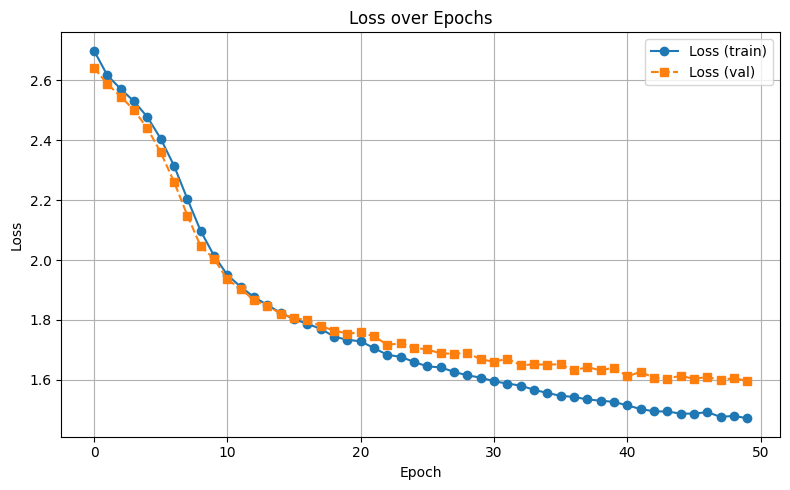

Saved Accuracy plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-05_accuracy_20250520-014249_normalized_ce.png


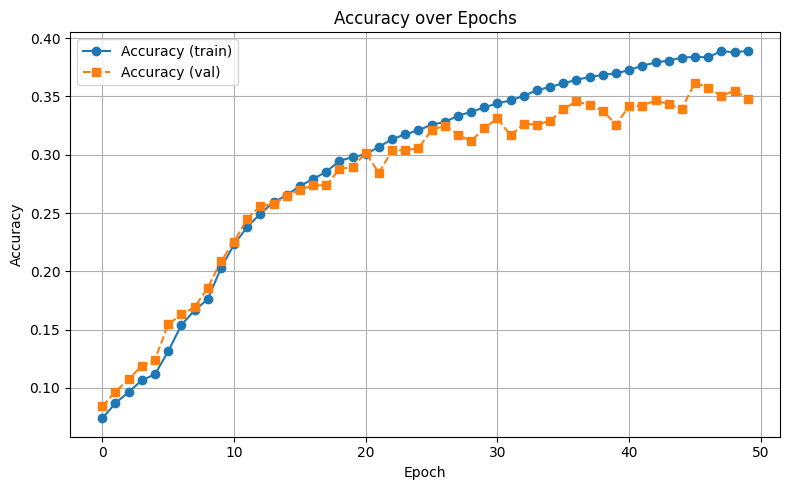

Saved Iou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-05_iou_20250520-014249_normalized_ce.png


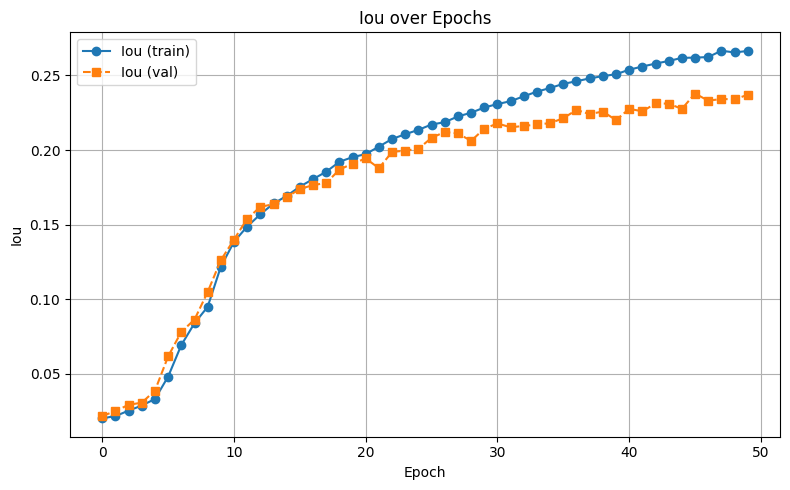

Saved Dice plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-05_dice_20250520-014249_normalized_ce.png


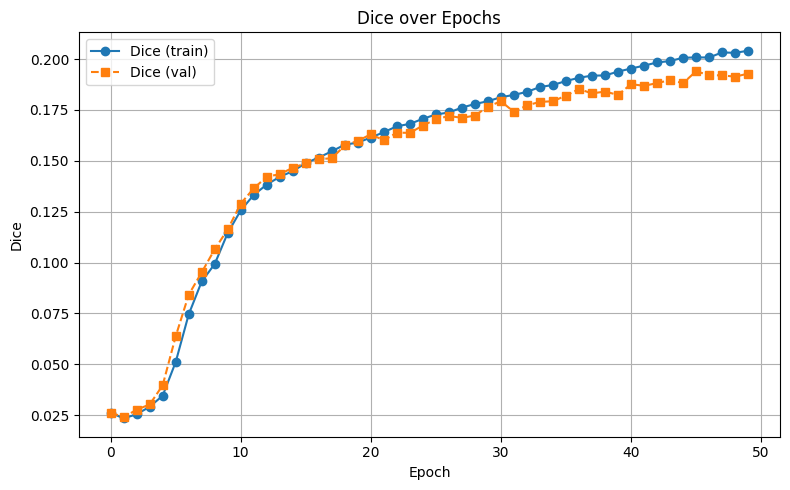

Saved Miou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-05_miou_20250520-014249_normalized_ce.png


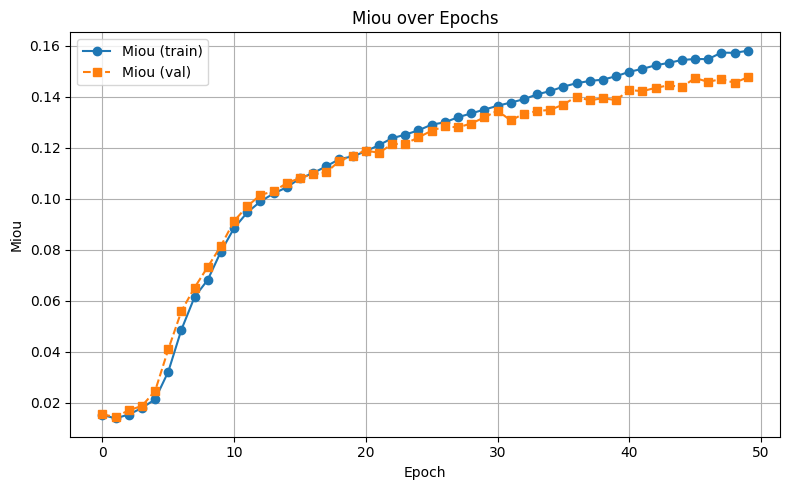

In [13]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

all_metrics = {
    'loss':  (train_losses, val_losses),
    'accuracy': (train_accs, val_accs),
    'iou':    (train_ious, val_ious),
    'dice':   (train_dices, val_dices),
    'miou':   (train_mious, val_mious),
}

for metric_name, (train_vals, val_vals) in all_metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, marker='o', linestyle='-', label=f'{metric_name.title()} (train)')
    plt.plot(val_vals,   marker='s', linestyle='--', label=f'{metric_name.title()} (val)')
    plt.title(f'{metric_name.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # build a descriptive filename
    filename = (
        f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
        f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_"
        f"{metric_name}_{timestamp}_normalized_ce.png"
    )
    save_path = os.path.join(UNET_GRAPH_FOLDER, filename)

    # save and show
    plt.savefig(save_path, dpi=300)
    print(f"Saved {metric_name.title()} plot to: {save_path}")
    plt.show()

In [14]:

os.makedirs(UNET_MODEL_FOLDER, exist_ok=True)

model_filename = (
    f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_"
    f"lr{LEARNING_RATE:.0e}_normalized_ce.pth"
)

model_path = os.path.join(UNET_MODEL_FOLDER, model_filename)


torch.save(model.state_dict(), model_path)
print(f"Saved model checkpoint to: {model_path}")


Saved model checkpoint to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/models/unet++_resnet34_None_32bs_50ep_lr1e-05_normalized_ce.pth


In [15]:
os.makedirs(UNET_METRICS_FOLDER, exist_ok=True)

# Build a DataFrame with both train & val metrics
metrics_df = pd.DataFrame({
    'Epoch':        list(range(1, len(train_losses) + 1)),
    'train_Loss':   train_losses,
    'train_Acc':    train_accs,
    'train_IoU':    train_ious,
    'train_Dice':   train_dices,
    'train_mIoU':   train_mious,
    'val_Loss':     val_losses,
    'val_Acc':      val_accs,
    'val_IoU':      val_ious,
    'val_Dice':     val_dices,
    'val_mIoU':     val_mious,
})

# Descriptive filename using your hyper-params
csv_filename = (
    f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_normalized_ce_metrics.csv"
)
csv_path = os.path.join(UNET_METRICS_FOLDER, csv_filename)

# Save!
metrics_df.to_csv(csv_path, index=False)
print(f"Saved all train/val metrics to: {csv_path}")


Saved all train/val metrics to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/metrics/unet++_resnet34_None_32bs_50ep_lr1e-05_normalized_ce_metrics.csv
